In [6]:
# load Google Driver
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
my_path = '/content/drive/My Drive/Colab Notebooks/EVA 5/11.superconvergence/'


Mounted at /content/drive


In [7]:
!rm -rf '/content/drive/My Drive/Colab Notebooks/EVA 5/11.superconvergence/__pycache__'
!ls -lrt '/content/drive/My Drive/Colab Notebooks/EVA 5/11.superconvergence/'

total 54835
-rw------- 1 root root     3694 Oct 10 17:05  VS_NET.py
-rw------- 1 root root     5554 Oct 10 17:05  Test_Train_OCP.py
-rw------- 1 root root     4482 Oct 10 17:05  Resnet.py
-rw------- 1 root root      599 Oct 10 17:05  README.md
-rw------- 1 root root     4077 Oct 10 17:05  QuizDNN.py
-rw------- 1 root root     3657 Oct 10 17:05  Plots.py
-rw------- 1 root root    31322 Oct 10 17:05  grid_image.png
-rw------- 1 root root     5882 Oct 10 17:05  GradCam.py
-rw------- 1 root root    20889 Oct 10 17:05 'EVA5 Assignment 9a'
-rw------- 1 root root     3051 Oct 10 17:05  DH_NET.py
-rw------- 1 root root     4849 Oct 10 17:05  dataTorchTransformLoad.py
-rw------- 1 root root     5380 Oct 10 17:05  Test_Train.py
drwx------ 2 root root     4096 Oct 10 17:06  outputs
-rw------- 1 root root  1275057 Oct 10 18:24  01-Super-convergence.ipynb
-rw------- 1 root root     2132 Oct 11 13:48  dataAlbumentationLoad.py
-rw------- 1 root root  1084764 Oct 11 14:43  02-Super-convergence_Prasad.

In [8]:
# import

from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.functional as F
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
import sys
import random
import matplotlib

In [10]:
# import for all the modular codes
import VS_NET
import Test_Train
import Test_Train_OCP
import Plots
import dataTorchTransformLoad as dtl
import Resnet
import GradCam
import Resnet
import dataAlbumentationLoad as dal
import GradCam
from GradCam import GradCAM, visualize_cam, save_misclassified, download_img_pil,pil_img_transform
from Plots import plot_misclassified,imshow
import DH_NET

In [9]:
sys.path.append('/content/drive/My Drive/Colab Notebooks/EVA 5/11.superconvergence/')

In [11]:
my_path

'/content/drive/My Drive/Colab Notebooks/EVA 5/11.superconvergence/'

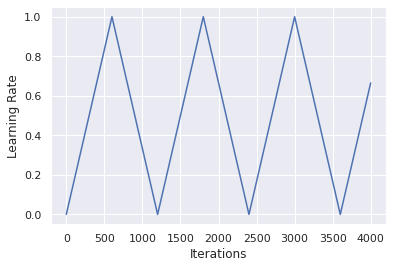

In [34]:
def get_triangular_lr(iteration, stepsize, base_lr, max_lr):
    """Given the inputs, calculates the lr that should be applicable for this iteration"""
    cycle = np.floor(1 + iteration/(2  * stepsize))
    x = np.abs(iteration/stepsize - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * np.maximum(0, (1-x))
    return lr

# Demo of how the LR varies with iterations
num_iterations = 4000
stepsize = 600
base_lr = 1e-4
max_lr = 1
lr_trend = list()

for iteration in range(num_iterations):
    lr = get_triangular_lr(iteration, stepsize, base_lr, max_lr)
    # Update your optimizer to use this learning rate in this iteration
    lr_trend.append(lr)
plt.xlabel("Iterations")
plt.ylabel("Learning Rate")
plt.plot(lr_trend)

In [7]:
# def imshow(img):
#     # img = img / 2 + 0.5     # unnormalize
#     img[0] = img[0]*0.24703223 + 0.49139968
#     img[1] = img[1]*0.24348513 + 0.48215841
#     img[2] = img[2]*0.26158784 + 0.44653091
#     npimg = img.numpy()
#     image = np.transpose(npimg, (1, 2, 0))
#     plt.imshow(image)
#     plt.grid(b=None)
#     return image

def imshow1(img,c = "" ):
  #img = img / 2 + 0.5     # unnormalize
  npimg = img.numpy()
  fig = plt.figure(figsize=(15,15))
  plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')
  plt.title(c)
  plt.grid(b=None)
  plt.savefig(my_path+'/grid_image.png')

In [12]:

#initializers 
dropout_value = 0.05
num_splits=2
start_epoch=0
EPOCHS = 24
EPOCHS1 = 50
input_ch=3
best_acc = 90

metric_values = {}
models={}

batch_size_GPU=512
batch_size_CPU=16

model_save_path = my_path+"/best_model.pt"


In [13]:
import albumentations as A

channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
train_transform = dal.AlbumentationTransforms([
                                       A.RandomCrop(32,32, p = 4),
                                       A.HorizontalFlip(),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       A.Cutout(num_holes=1, max_h_size=8,max_w_size = 8,p=1 )
                                       ])
# # Test Phase transformations
test_transform = dal.AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])

In [14]:
classes, train_loader, test_loader = dal.load(train_transform,test_transform, batch_size=512)


Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


In [15]:
len(test_loader), len(train_loader)

(20, 98)

In [16]:
10000/512, 50000/512

(19.53125, 97.65625)

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=train_transform)
    #print(vars(train_set))
print("Shape : ", train_set.data.shape)
print("Mean : ",train_set.data.mean(axis=(0,1,2))/255)
print("Std : ",train_set.data.std(axis=(0,1,2))/255)
print("Min : ",train_set.data.min(axis=(0,1,2))/255)
print("Max : ",train_set.data.max(axis=(0,1,2))/255)

Files already downloaded and verified
Shape :  (50000, 32, 32, 3)
Mean :  [0.49139968 0.48215841 0.44653091]
Std :  [0.24703223 0.24348513 0.26158784]
Min :  [0. 0. 0.]
Max :  [1. 1. 1.]


<Figure size 432x288 with 0 Axes>

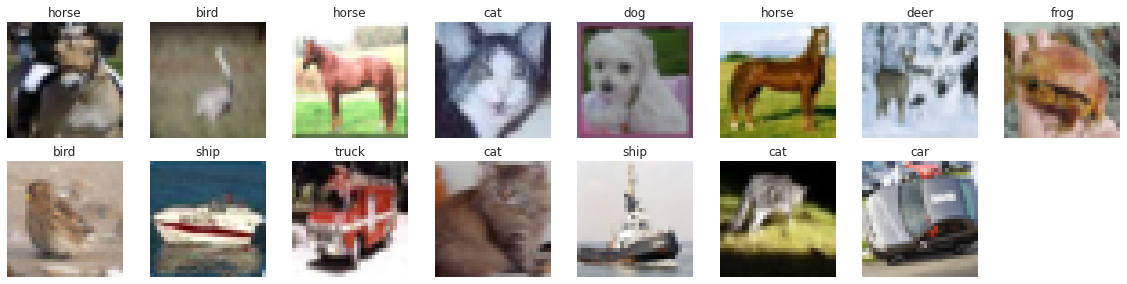

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# plt.style.use('dark_background')
figure = plt.figure()
plt.figure(figsize=(20,20))
num_of_images = 16
for index in range(1, num_of_images):
    plt.subplot(8, 8, index)
    plt.axis('off')
    plt.title(classes[labels[index].item()])
    imshow(images[index])

#DH_NET

In [17]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = DH_NET.Net().to(device)

In [18]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

# LR Finder

In [ ]:
!pip install torch_lr_finder
from torch_lr_finder import LRFinder
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=1e-05,momentum=0.9 ,weight_decay = 0.0001)
lr_finder = LRFinder(model, optimiser, criterion, device="cuda")
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=1, num_iter=98 ,step_mode="exp")
print(lr_finder)

LR suggestion: steepest gradient
Suggested LR: 4.25E-03


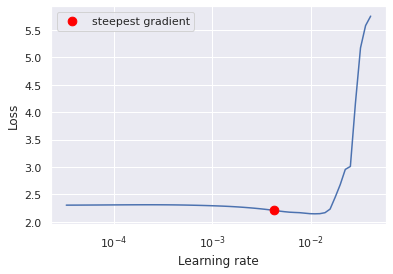

(<matplotlib.axes._subplots.AxesSubplot at 0x7f14c4ead908>,
 0.00425467096331598)

In [ ]:
lr_finder.plot(log_lr=True)

In [17]:
ideal_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]
#lr_finder.reset()

In [25]:
print(ideal_lr)

0.00976541539256097


# Max LR Finder

use step scheduler to increase the learning rate from 0.0001 to 0.03 with 2 steps per epoch. 

Identify the learning rate with max accuracy. 

In [20]:

# Uses Step lr to change the learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9,nesterov=False)
scheduler = StepLR(optimizer, step_size=2, gamma=1.8)

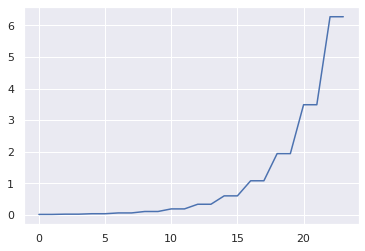

In [22]:
lr_list =[]
for i in range(EPOCHS):
  # print('EPOCH',i)
  # print(optimizer.param_groups[0]['lr'])
  lr_list.append(optimizer.param_groups[0]['lr'])
  optimizer.step()
  scheduler.step()
plt.plot(lr_list) 

In [21]:
exp_name = 'Best Learning Rate'

trainer = Test_Train_OCP.Trainer(model,device,train_loader,test_loader,optimizer,start_epoch,EPOCHS,scheduler,model_save_path,best_acc)
train_metric, test_metric,learning_rate = trainer.train(l1_lambda=0, l2_lambda=0)

# save the metrics in dictionary
metric_values[exp_name] = (train_metric, test_metric)

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 0
learning rate  0.001


Loss=1.3327585458755493 Batch_id=97 Accuracy=40.20: 100%|██████████| 98/98 [00:24<00:00,  4.05it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.3237, Accuracy: 5212/10000 (52.12%)

emptying the cache
EPOCH: 1
learning rate  0.001


Loss=1.0857518911361694 Batch_id=97 Accuracy=56.79: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.1248, Accuracy: 5951/10000 (59.51%)

EPOCH: 2
learning rate  0.0018000000000000002


Loss=1.068009376525879 Batch_id=97 Accuracy=63.22: 100%|██████████| 98/98 [00:24<00:00,  3.93it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.0195, Accuracy: 6360/10000 (63.60%)

EPOCH: 3
learning rate  0.0018000000000000002


Loss=0.8226189613342285 Batch_id=97 Accuracy=69.76: 100%|██████████| 98/98 [00:24<00:00,  3.99it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9617, Accuracy: 6639/10000 (66.39%)

EPOCH: 4
learning rate  0.0032400000000000003


Loss=0.7389047145843506 Batch_id=97 Accuracy=73.06: 100%|██████████| 98/98 [00:24<00:00,  3.93it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.8138, Accuracy: 7166/10000 (71.66%)

EPOCH: 5
learning rate  0.0032400000000000003


Loss=0.6101453304290771 Batch_id=97 Accuracy=77.37: 100%|██████████| 98/98 [00:25<00:00,  3.92it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7355, Accuracy: 7475/10000 (74.75%)

EPOCH: 6
learning rate  0.005832


Loss=0.5087488889694214 Batch_id=97 Accuracy=77.26: 100%|██████████| 98/98 [00:24<00:00,  3.93it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7830, Accuracy: 7364/10000 (73.64%)

EPOCH: 7
learning rate  0.005832


Loss=0.40145134925842285 Batch_id=97 Accuracy=81.63: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7496, Accuracy: 7520/10000 (75.20%)

EPOCH: 8
learning rate  0.010497600000000001


Loss=0.652307391166687 Batch_id=97 Accuracy=79.54: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7661, Accuracy: 7555/10000 (75.55%)

EPOCH: 9
learning rate  0.010497600000000001


Loss=0.5893598198890686 Batch_id=97 Accuracy=83.71: 100%|██████████| 98/98 [00:24<00:00,  3.94it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6190, Accuracy: 7998/10000 (79.98%)

EPOCH: 10
learning rate  0.01889568


Loss=0.5561005473136902 Batch_id=97 Accuracy=77.08: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7603, Accuracy: 7655/10000 (76.55%)

emptying the cache
EPOCH: 11
learning rate  0.01889568


Loss=0.4333566427230835 Batch_id=97 Accuracy=83.54: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6358, Accuracy: 8141/10000 (81.41%)

EPOCH: 12
learning rate  0.034012224


Loss=0.7636502385139465 Batch_id=97 Accuracy=71.98: 100%|██████████| 98/98 [00:24<00:00,  3.93it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6984, Accuracy: 7909/10000 (79.09%)

EPOCH: 13
learning rate  0.034012224


Loss=0.431537389755249 Batch_id=97 Accuracy=83.78: 100%|██████████| 98/98 [00:24<00:00,  3.94it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6167, Accuracy: 8228/10000 (82.28%)

EPOCH: 14
learning rate  0.0612220032


Loss=0.7678978443145752 Batch_id=97 Accuracy=69.74: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.3888, Accuracy: 6982/10000 (69.82%)

EPOCH: 15
learning rate  0.0612220032


Loss=0.447781503200531 Batch_id=97 Accuracy=82.33: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4592, Accuracy: 8542/10000 (85.42%)

EPOCH: 16
learning rate  0.11019960576


Loss=0.5814327597618103 Batch_id=97 Accuracy=82.64: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5575, Accuracy: 8312/10000 (83.12%)

EPOCH: 17
learning rate  0.11019960576


Loss=0.4085465967655182 Batch_id=97 Accuracy=88.04: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5633, Accuracy: 8353/10000 (83.53%)

EPOCH: 18
learning rate  0.198359290368


Loss=0.580238401889801 Batch_id=97 Accuracy=77.31: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5274, Accuracy: 8265/10000 (82.65%)

EPOCH: 19
learning rate  0.198359290368


Loss=0.4744760990142822 Batch_id=97 Accuracy=87.54: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4385, Accuracy: 8596/10000 (85.96%)

EPOCH: 20
learning rate  0.3570467226624


Loss=0.5125204920768738 Batch_id=97 Accuracy=86.42: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6487, Accuracy: 7982/10000 (79.82%)

emptying the cache
EPOCH: 21
learning rate  0.3570467226624


Loss=0.33281487226486206 Batch_id=97 Accuracy=88.96: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5194, Accuracy: 8525/10000 (85.25%)

EPOCH: 22
learning rate  0.6426841007923201


Loss=0.4724157452583313 Batch_id=97 Accuracy=84.61: 100%|██████████| 98/98 [00:24<00:00,  3.94it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6067, Accuracy: 7999/10000 (79.99%)

EPOCH: 23
learning rate  0.6426841007923201


Loss=0.6282763481140137 Batch_id=97 Accuracy=79.31: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s]



Test set: Average loss: 0.6560, Accuracy: 7947/10000 (79.47%)



Best ACC and Learning Rate are 0.6426841007923201 88.962 0.3570467226624


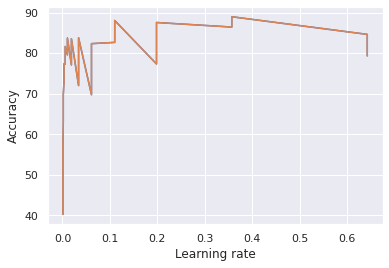

In [22]:
# plt the learning rate vs. accuracy. Get the best acc. 

(lr,acc) = learning_rate
plt.plot(lr,acc)
plt.plot(lr[:],acc[:]) # Zoom the plt a little bit. 
plt.ylabel('Accuracy')
plt.xlabel('Learning rate')
best_acc = lr[acc.index(max(acc))] # get the index where acc is max and get the learning rate of that index. 

print('Best ACC and Learning Rate are', max(lr), max(acc), best_acc)

Epochs = 24, 
batch size = 512
number of batchs per epoch = 50k/512 = 98

Max at 5 epochs - 5*98 = 490 step. 


# Learning Rate Finder - Increase the learning rate from low value to high value. 

Plot learning rate vs accuracy to come up with max learning rate. 

In [25]:
# one cycle LR

# best_acc=0.03

from torch.optim.lr_scheduler import OneCycleLR

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=best_acc, momentum=0.9, nesterov=False)

scheduler =OneCycleLR(optimizer, max_lr=best_acc, steps_per_epoch=1,
                      epochs=EPOCHS,div_factor = 100,final_div_factor=1,pct_start=5/EPOCHS,
                      anneal_strategy="linear")#,cycle_momentum=False,div_factor = 10, final_div_factor = 1)



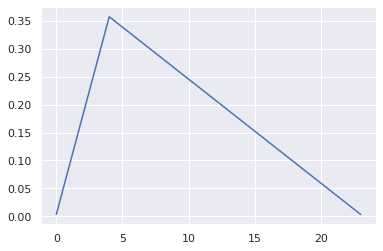

In [24]:
lr_list =[]
for i in range(EPOCHS):
  # print('EPOCH',i)
  # print(optimizer.param_groups[0]['lr'])
  lr_list.append(optimizer.param_groups[0]['lr'])
  optimizer.step()
  scheduler.step()
plt.plot(lr_list) 

In [26]:
exp_name = 'ONe cycle policy'

trainer = Test_Train_OCP.Trainer(model,device,train_loader,test_loader,optimizer,start_epoch,EPOCHS,scheduler,model_save_path,best_acc)
train_metric, test_metric,learning_rate = trainer.train(l1_lambda=0, l2_lambda=0)

# save the metrics in dictionary
metric_values[exp_name] = (train_metric, test_metric)

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 0
learning rate  0.003570467226624


Loss=1.5111966133117676 Batch_id=97 Accuracy=39.92: 100%|██████████| 98/98 [00:25<00:00,  3.91it/s]



Test set: Average loss: 1.5622, Accuracy: 5105/10000 (51.05%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
emptying the cache
EPOCH: 1
learning rate  0.091939531085568


Loss=0.5205193161964417 Batch_id=97 Accuracy=72.89: 100%|██████████| 98/98 [00:25<00:00,  3.91it/s]



Test set: Average loss: 0.5551, Accuracy: 8164/10000 (81.64%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 2
learning rate  0.18030859494451199


Loss=0.34764283895492554 Batch_id=97 Accuracy=85.64: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s]



Test set: Average loss: 0.4719, Accuracy: 8445/10000 (84.45%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 3
learning rate  0.268677658803456


Loss=0.3713853359222412 Batch_id=97 Accuracy=88.82: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s]



Test set: Average loss: 0.4379, Accuracy: 8582/10000 (85.82%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 4
learning rate  0.3570467226624


Loss=0.3258959650993347 Batch_id=97 Accuracy=90.82: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s]



Test set: Average loss: 0.4800, Accuracy: 8508/10000 (85.08%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 5
learning rate  0.3384427092184118


Loss=0.21156471967697144 Batch_id=97 Accuracy=92.38: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s]



Test set: Average loss: 0.4034, Accuracy: 8800/10000 (88.00%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 6
learning rate  0.3198386957744236


Loss=0.1566920131444931 Batch_id=97 Accuracy=93.47: 100%|██████████| 98/98 [00:24<00:00,  3.98it/s]



Test set: Average loss: 0.4078, Accuracy: 8843/10000 (88.43%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 7
learning rate  0.3012346823304354


Loss=0.10332485288381577 Batch_id=97 Accuracy=94.53: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s]



Test set: Average loss: 0.4594, Accuracy: 8759/10000 (87.59%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 8
learning rate  0.28263066888644717


Loss=0.10604455322027206 Batch_id=97 Accuracy=95.43: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s]



Test set: Average loss: 0.4752, Accuracy: 8739/10000 (87.39%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 9
learning rate  0.26402665544245896


Loss=0.1741635799407959 Batch_id=97 Accuracy=95.80: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s]



Test set: Average loss: 0.4379, Accuracy: 8863/10000 (88.63%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 10
learning rate  0.24542264199847075


Loss=0.10595831274986267 Batch_id=97 Accuracy=96.53: 100%|██████████| 98/98 [00:24<00:00,  3.94it/s]



Test set: Average loss: 0.4545, Accuracy: 8839/10000 (88.39%)

...BEST MODEL...
Save success...


  0%|          | 0/98 [00:00<?, ?it/s]

emptying the cache
EPOCH: 11
learning rate  0.22681862855448254


Loss=0.0613643154501915 Batch_id=97 Accuracy=96.87: 100%|██████████| 98/98 [00:24<00:00,  3.98it/s]



Test set: Average loss: 0.4677, Accuracy: 8851/10000 (88.51%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 12
learning rate  0.20821461511049433


Loss=0.13107681274414062 Batch_id=97 Accuracy=97.19: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s]



Test set: Average loss: 0.5012, Accuracy: 8827/10000 (88.27%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 13
learning rate  0.18961060166650612


Loss=0.06936434656381607 Batch_id=97 Accuracy=97.74: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s]



Test set: Average loss: 0.4507, Accuracy: 8911/10000 (89.11%)

...BEST MODEL...
Save success...
EPOCH: 14
learning rate  0.1710065882225179


Loss=0.03478862717747688 Batch_id=97 Accuracy=97.91: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s]



Test set: Average loss: 0.4832, Accuracy: 8911/10000 (89.11%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 15
learning rate  0.1524025747785297


Loss=0.06049540638923645 Batch_id=97 Accuracy=98.22: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s]



Test set: Average loss: 0.5045, Accuracy: 8890/10000 (88.90%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 16
learning rate  0.1337985613345415


Loss=0.04909142851829529 Batch_id=97 Accuracy=98.40: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s]



Test set: Average loss: 0.5067, Accuracy: 8915/10000 (89.15%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 17
learning rate  0.11519454789055328


Loss=0.04836173728108406 Batch_id=97 Accuracy=98.73: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s]



Test set: Average loss: 0.4819, Accuracy: 8981/10000 (89.81%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 18
learning rate  0.09659053444656507


Loss=0.040741197764873505 Batch_id=97 Accuracy=98.80: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]



Test set: Average loss: 0.4785, Accuracy: 8984/10000 (89.84%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 19
learning rate  0.07798652100257686


Loss=0.007666494231671095 Batch_id=97 Accuracy=99.03: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s]



Test set: Average loss: 0.4860, Accuracy: 9058/10000 (90.58%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 20
learning rate  0.05938250755858865


Loss=0.02170400880277157 Batch_id=97 Accuracy=99.18: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]



Test set: Average loss: 0.4762, Accuracy: 9027/10000 (90.27%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
emptying the cache
EPOCH: 21
learning rate  0.04077849411460044


Loss=0.0209543127566576 Batch_id=97 Accuracy=99.32: 100%|██████████| 98/98 [00:25<00:00,  3.91it/s]



Test set: Average loss: 0.4793, Accuracy: 9020/10000 (90.20%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 22
learning rate  0.02217448067061223


Loss=0.015601965598762035 Batch_id=97 Accuracy=99.47: 100%|██████████| 98/98 [00:25<00:00,  3.92it/s]



Test set: Average loss: 0.4717, Accuracy: 9053/10000 (90.53%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 23
learning rate  0.003570467226624019


Loss=0.0059045650996267796 Batch_id=97 Accuracy=99.44: 100%|██████████| 98/98 [00:25<00:00,  3.89it/s]



Test set: Average loss: 0.4702, Accuracy: 9061/10000 (90.61%)

...BEST MODEL...
Save success...


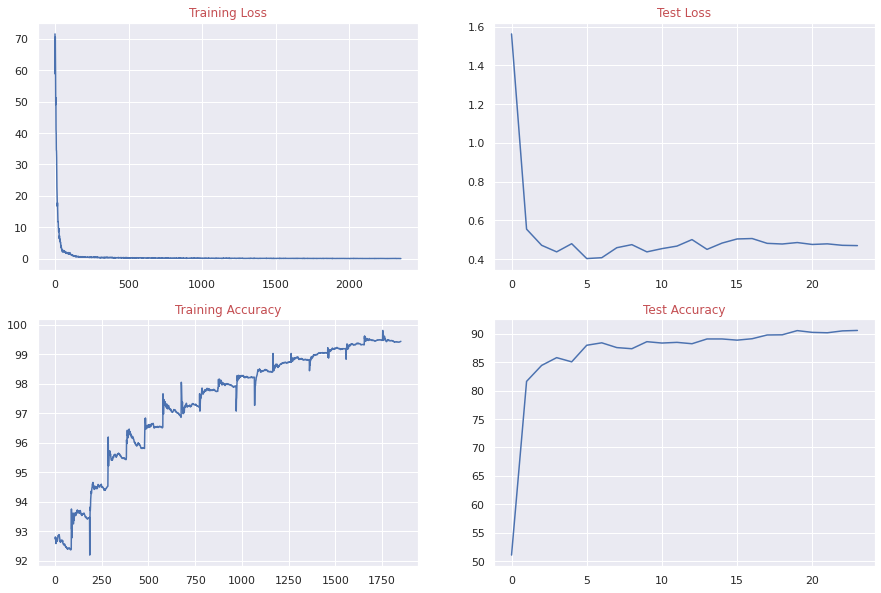

In [27]:
Plots.plot_metrics(train_metric, test_metric)

# Plot misclassified

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


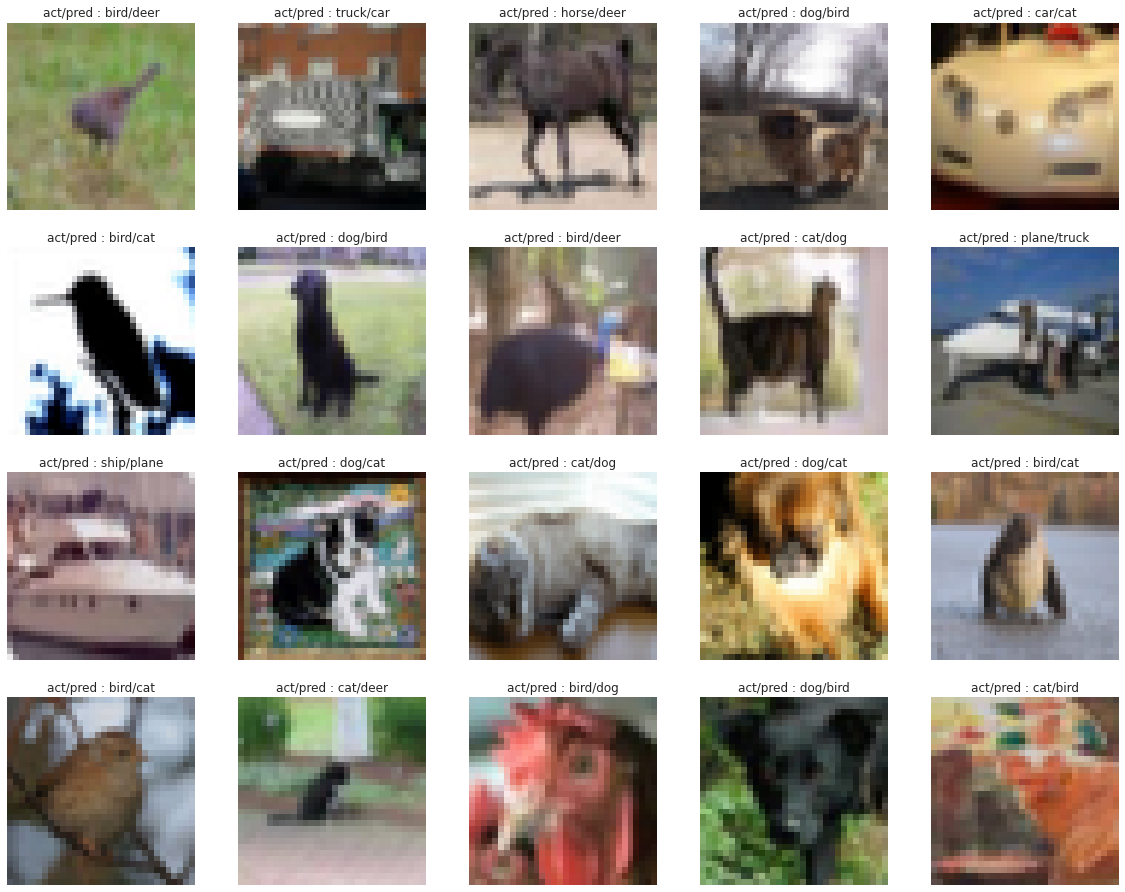

In [28]:
misclass_img_list = plot_misclassified(model, test_loader, device,classes)

In [29]:
len(misclass_img_list)

20

In [ ]:
mis_img_name_list = save_misclassified(misclass_img_list)
pil_image = download_img_pil(mis_img_name_list)
torch_img_list,normed_torch_img = pil_img_transform(pil_image,device)

In [ ]:
len(mis_img_name_list), len(pil_image), len(torch_img_list)

In [ ]:

import copy
from torchvision.utils import make_grid, save_image

for i,k in enumerate(normed_torch_img):
  images1 = [torch_img_list[i].cpu()]
  images2 =  [torch_img_list[i].cpu()]
  b = copy.deepcopy(model.to(device))
  output = model(normed_torch_img[i])
  _, predicted = torch.max(output.data, 1)
  #print(classes[int(predicted)])
  layers =  [b.layer1,b.layer2,b.layer3,b.layer4]
  for j in layers:
    g = GradCAM(b,j)
    mask, _= g(normed_torch_img[i])
    heatmap, result = visualize_cam(mask,torch_img_list[i] )
    images1.extend([heatmap])
    images2.extend([result])
    

  grid_image = make_grid(images2,nrow=5,padding=2,normalize=False)

  imshow1(grid_image,c = classes[int(predicted)])